In [191]:
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [47]:
def get_day_load_data(load_path):
    '''read csv data at load_path and return it in a numpy matrix'''
    data = pd.read_csv(load_path)
    date_ = load_path.split('/')[-1][:-4] # get date of '01-10-2017' format
    data['date'] = datetime.strptime(date_, "%d-%m-%Y").date()
    data['time'] += ':00'
    data['datetime'] = pd.to_timedelta(data['time'])
    data['hour'] = data['datetime'].dt.seconds // 3600 
    return data.as_matrix()

In [218]:
def get_30min_wise_data(day_load_data, day_whether_data):
    '''Returns time, day temp, humidity and load values for each 30mins in a numpy matrix'''
    data = []
    for i in range(0, 288, 6): # SLDC load data has time step of 5 mins, so total 24 * (60 // 5)
        load = day_load_data[i][1]
        day = day_load_data[i][2].weekday()
        
        try:
            humidity = float(day_whether_data[i//6][1].replace('%', ''))
        except Exception as e:
            humidity = 50 # some dirt values in data
        try:
            temp = float(day_whether_data[i//6][0]) # i//6 because whether data is already in 30 min step size
        except Exception as err:
            temp = 28 # aiyvi
        data.append([i, day, temp, humidity, load])
    return np.asarray(data)

In [219]:
def get_data(data_list):
    '''Return data of all csv files in SLDC_Data/ folder in matrix form'''
    data = []
    for load_path in data_list:
        try:
            whether_path = load_path.replace('SLDC_Data', 'Whether_Data')
            day_load_data = get_day_load_data(load_path)
            day_whether_data = pd.read_csv(whether_path)
            day_data = get_30min_wise_data(day_load_data, day_whether_data[['Temp.', 'Humidity']].as_matrix())
            data.append(day_data)
        except Exception as e:
            print(load_path, e)
    data = np.asarray(data) # (115, 48, 5)
    data = data.reshape(-1, 5) # (5520, 5)
    np.random.shuffle(data)
    return data

In [231]:
# data preprocessing
data_list = glob.glob('SLDC_Data/*/*/*.csv')
train, test = train_test_split(data_list, test_size=0.1)

train_data = get_data(train)
test_data = get_data(test)

X_train = train_data[:, :-1] # features
Y_train = train_data[:, -1].reshape(-1, 1) # load, reshaped to 2D
X_test = test_data[:, :-1] # features
Y_test = test_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

SLDC_Data/2017/12/07-12-2017.csv index 132 is out of bounds for axis 0 with size 132
SLDC_Data/2018/01/19-01-2018.csv index 168 is out of bounds for axis 0 with size 168
SLDC_Data/2018/01/04-01-2018.csv index 276 is out of bounds for axis 0 with size 276


In [232]:
# rescale the data to 0-1 values`
feature_scaler = MinMaxScaler(feature_range=(0, 1))
load_scaler = MinMaxScaler(feature_range=(0, 1)) # try StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.fit_transform(X_test)

Y_train = load_scaler.fit_transform(Y_train)
Y_test = load_scaler.fit_transform(Y_test)

In [233]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6000, 4), (6000, 1), (720, 4), (720, 1))

In [239]:
def getModel():
    model = Sequential()
    model.add(Dense(16, input_shape=(4, )))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

In [240]:
model = getModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                80        
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_8 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total para

In [241]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.2, shuffle=True)

Train on 4800 samples, validate on 1200 samples
Epoch 1/50
4800/4800 [==============================] - 1s 128us/step - loss: 0.0382 - val_loss: 0.0266
Epoch 2/50
4800/4800 [==============================] - 0s 76us/step - loss: 0.0211 - val_loss: 0.0185
Epoch 3/50
4800/4800 [==============================] - 0s 70us/step - loss: 0.0158 - val_loss: 0.0144
Epoch 4/50
4800/4800 [==============================] - 0s 78us/step - loss: 0.0130 - val_loss: 0.0118
Epoch 5/50
4800/4800 [==============================] - 0s 65us/step - loss: 0.0110 - val_loss: 0.0103
Epoch 6/50
4800/4800 [==============================] - 0s 51us/step - loss: 0.0098 - val_loss: 0.0093
Epoch 7/50
4800/4800 [==============================] - 1s 106us/step - loss: 0.0091 - val_loss: 0.0087
Epoch 8/50
4800/4800 [==============================] - 1s 106us/step - loss: 0.0087 - val_loss: 0.0087
Epoch 9/50
4800/4800 [==============================] - 0s 75us/step - loss: 0.0083 - val_loss: 0.0081
Epoch 10/50
4800/4800 

435 485


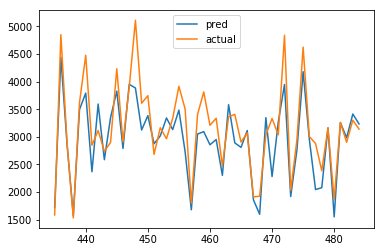

In [243]:
# prediction on test data

preds = model.predict(X_test)
preds = load_scaler.inverse_transform(preds)
Y_ = load_scaler.inverse_transform(Y_test)

x = np.random.randint(len(preds))
x_max = 50
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()

2574 2624


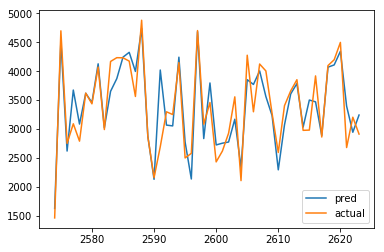

In [244]:
# prediction on train data

preds = model.predict(X_train)
preds = load_scaler.inverse_transform(preds)
Y_ = load_scaler.inverse_transform(Y_train)

x = np.random.randint(len(preds))
x_max = 50
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()